# Natural Disaster Prediction
## Moa, Olivia, Chrysoula

This project focuses on detecting disasters using tweets. The challenge is that there are tweets about real disasters or not real. Thus, a machine learning model will be trained to predict natural disaster.

We add the Maven dependency for MLeap: Go to Workplace>Create>Library>Maven, add the dependency to the Coordinate field: ml.combust.mleap:mleap-spark_2.12:0.20.0

We import and install all the required packages etc.:

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover, StringIndexer
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from delta import *
import random
import pyspark.pandas as ps
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import string

In [0]:
%sh
pip install wordcloud

You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


# Load Data & Pre-Processing

Fistly, we upload the train.csv and test.csv file in the DBFS manually from Kaggle (https://www.kaggle.com/competitions/nlp-getting-started/).

Then, a **SparkSession** is defined with the right configuration to support Lakehouse and the data are read into a **DataFrame**.

The *printSchema* method shows the schema of the data which in our case has the columns: id, keyword, location, text and target.

In [0]:
# init SparkSession
builder = SparkSession.builder.master("local[1]").appName("DisasterPrediction").config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension").config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
spark = configure_spark_with_delta_pip(builder).getOrCreate()
# read train.cvs file
df_csv = spark.read.option("header",True).csv("/FileStore/tables/train.csv")
# print schema
df_csv.printSchema()

root
 |-- id: string (nullable = true)
 |-- keyword: string (nullable = true)
 |-- location: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: string (nullable = true)



The train set we have is shown below using the *show* method:

In [0]:
df_csv.show()

+---+-------+--------+--------------------+------+
| id|keyword|location|                text|target|
+---+-------+--------+--------------------+------+
|  1|   null|    null|Our Deeds are the...|     1|
|  4|   null|    null|Forest fire near ...|     1|
|  5|   null|    null|All residents ask...|     1|
|  6|   null|    null|13,000 people rec...|     1|
|  7|   null|    null|Just got sent thi...|     1|
|  8|   null|    null|#RockyFire Update...|     1|
| 10|   null|    null|#flood #disaster ...|     1|
| 13|   null|    null|I'm on top of the...|     1|
| 14|   null|    null|There's an emerge...|     1|
| 15|   null|    null|I'm afraid that t...|     1|
| 16|   null|    null|Three people died...|     1|
| 17|   null|    null|Haha South Tampa ...|     1|
| 18|   null|    null|#raining #floodin...|     1|
| 19|   null|    null|#Flood in Bago My...|     1|
| 20|   null|    null|Damage to school ...|     1|
| 23|   null|    null|      What's up man?|     0|
| 24|   null|    null|       I 

We will not need all the columns, so we drop the keyword and location columns. 

The columns we keep are the following: id, text and target.

The **text** column will be used as an input to our model and the **target** as the output.

In [0]:
df_csv2 = df_csv.drop('keyword', 'location')
df_csv2.show()

+---+--------------------+------+
| id|                text|target|
+---+--------------------+------+
|  1|Our Deeds are the...|     1|
|  4|Forest fire near ...|     1|
|  5|All residents ask...|     1|
|  6|13,000 people rec...|     1|
|  7|Just got sent thi...|     1|
|  8|#RockyFire Update...|     1|
| 10|#flood #disaster ...|     1|
| 13|I'm on top of the...|     1|
| 14|There's an emerge...|     1|
| 15|I'm afraid that t...|     1|
| 16|Three people died...|     1|
| 17|Haha South Tampa ...|     1|
| 18|#raining #floodin...|     1|
| 19|#Flood in Bago My...|     1|
| 20|Damage to school ...|     1|
| 23|      What's up man?|     0|
| 24|       I love fruits|     0|
| 25|    Summer is lovely|     0|
| 26|   My car is so fast|     0|
| 28|What a goooooooaa...|     0|
+---+--------------------+------+
only showing top 20 rows



Then, we remove null values from text and target columns.

In [0]:
# remove null from text
df_csv3 = df_csv2.filter('text != " "')
# remove null from target
df_csv4 = df_csv3.filter(df_csv3.target.isNotNull())

We cast the target column from string to int to be compatible with the model.

In [0]:
df = df_csv4.withColumn("target", df_csv4.target.cast('int'))

We create the label distribution by counting the frequencies

In [0]:
# Convert a Pandas-on-Spark Dataframe into a Pandas Dataframe
pd_df = df.toPandas()
# Convert a Pandas Dataframe into a Pandas-on-Spark Dataframe
freq = pd_df['target'].value_counts()

We counted the frequency for each label.

In [0]:
print(freq)

0    4095
1    3081
Name: target, dtype: int64


We create a  visualization of the distribution with a pie plot. Since the distribution can be considered good we can proceed.

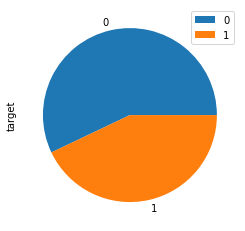

In [0]:
fig = freq.reset_index().plot.pie(y="target")

We create the **Word Cloud** for both labels.

In [0]:
# remove stop words, letters and some extra characters
my_stopwords = set(STOPWORDS)
for l in string.ascii_lowercase:
    my_stopwords.add(l)
my_stopwords.add("û_")
my_stopwords.add("û")
my_stopwords.add("Û_")
my_stopwords.add("Û")

Out[50]: <matplotlib.image.AxesImage at 0x7fb9a30f4d30>

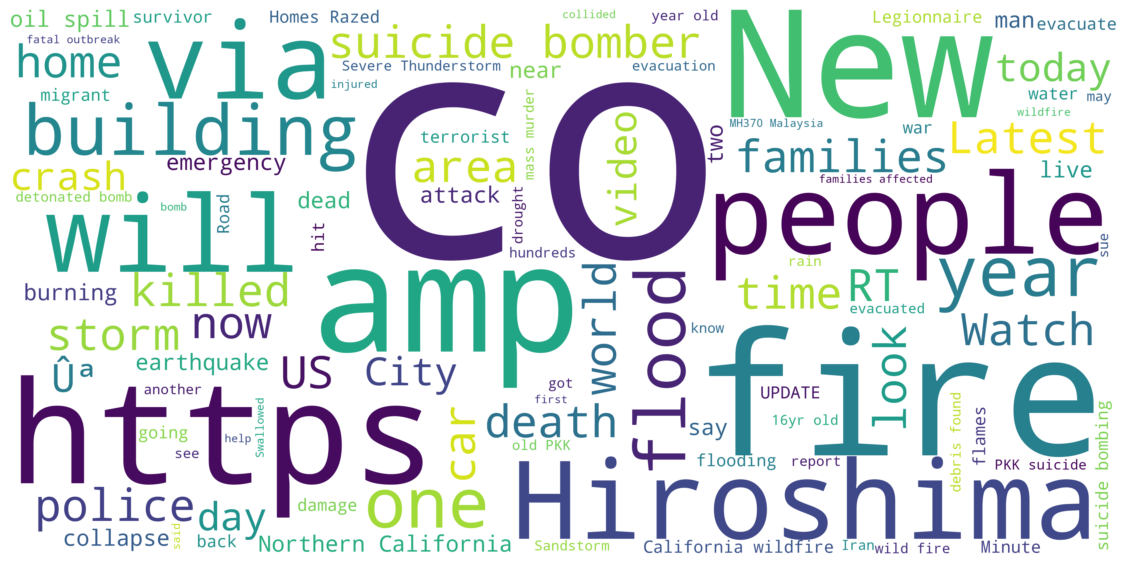

In [0]:
# Generate a word cloud image
wordcloud = WordCloud(scale=10
                     ,background_color="white"
                     ,stopwords=my_stopwords
                     ,random_state=1 # Make sure the output is always the same for the same input
             ).generate(' '.join(pd_df[pd_df.target==1]['text']))

# Display the generated image the matplotlib way:
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

Out[51]: <matplotlib.image.AxesImage at 0x7fb9a2d04a30>

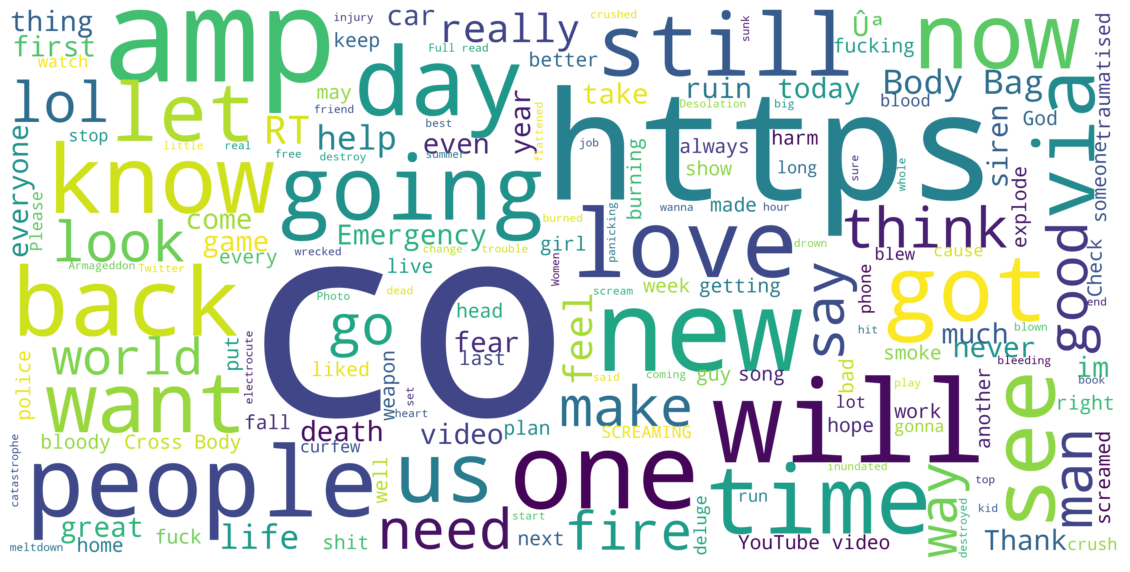

In [0]:
# Generate a word cloud image
wordcloud = WordCloud(scale=10
                     ,background_color="white"
                     ,stopwords=my_stopwords
                     ,random_state=1 # Make sure the output is always the same for the same input
             ).generate(' '.join(pd_df[pd_df.target==0]['text']))

# Display the generated image the matplotlib way:
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

We split the dataset into train (70%) and test set (30%).

In [0]:
(train, test) = df_csv4.randomSplit([.7, .3], 42)

# Save test data in Lakehouse

We write the test data in Lakehouse.

In [0]:
test_path = "/tmp/disaster-test-table1001"
test.write.format("delta").save(test_path)

Then, we read the test data from Lakehouse to see that everything works fine.

In [0]:
test = spark.read.format("delta").load(test_path)
test.show()

+-----+--------------------+------+
|   id|                text|target|
+-----+--------------------+------+
|  100|http://t.co/GKYe6...|     0|
|10004|@GreenLacey GodsL...|     0|
|10006|@Eric_Tsunami wor...|     0|
|10008|It's alil twister...|     1|
|10011|Just stop fucking...|     0|
|10013|love 106.1 The Tw...|     0|
|10014|Brain twister hom...|     0|
| 1002|Why Some Traffic ...|     0|
|10021|I'm in bed eating...|     0|
|10025|Last Second OutBi...|     0|
|10027|Reasons brain twi...|     0|
|10032|Anyone wanna come...|     0|
|10034|Crazy Mom Threw T...|     1|
|10035|@briannafrost Twi...|     0|
|10037|HAPPY 24 TWISTER!...|     0|
| 1004|I'm crazy enough ...|     0|
|10040|Tornadoes: El Nin...|     1|
|10045|TWISTER DANCE Gam...|     0|
|10049|Does the opening ...|     0|
| 1005|I'm blazing rn an...|     0|
+-----+--------------------+------+
only showing top 20 rows



# Model Training

We define the pipeline. We tokenize the words, remove stopwords and transform to TF-IDF.

The Machine Learning model is a Random Forest Classifier.

In [0]:
# Define pipeline components
label_indexer = StringIndexer(inputCol='target', outputCol='label')
tokenizer = Tokenizer(inputCol='text', outputCol='words')
remover = StopWordsRemover(inputCol='words', outputCol='filtered')
hashingTF = HashingTF(inputCol="filtered", outputCol="tf")
idf = IDF(inputCol="tf", outputCol="tfidf", minDocFreq=2)
rf = RandomForestClassifier(labelCol='label', featuresCol='tfidf')

# Define the pipeline
pipeline = Pipeline(stages=[label_indexer, tokenizer, remover, hashingTF, idf, rf])

We do CrossValidation using different value for the max depth and number of trees parameters on the train set.

Then, we choose the best model.

In [0]:
# Fit the model, performing cross validation 
evaluator = BinaryClassificationEvaluator()
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 10]).addGrid(rf.numTrees, [20, 50]).build()
cv = CrossValidator(estimator=pipeline, evaluator=evaluator, estimatorParamMaps=paramGrid)
cvModel = cv.fit(train)

# use the best model 
model = cvModel.bestModel

We display the predictions in the train set.

In [0]:
train_transformed = model.transform(train)
display(train_transformed)

id text target label words filtered tf tfidf rawPrediction probability prediction 1 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 1 1.0 List(our, deeds, are, the, reason, of, this, #earthquake, may, allah, forgive, us, all) List(deeds, reason, #earthquake, may, allah, forgive, us) Map(vectorType -> sparse, length -> 262144, indices -> List(24370, 35080, 68726, 91192, 109156, 157120, 243398), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(24370, 35080, 68726, 91192, 109156, 157120, 243398), values -> List(0.0, 5.835784921260449, 0.0, 4.573543208810537, 4.354180380336233, 5.653463364466494, 0.0)) Map(vectorType -> dense, length -> 2, values -> List(28.41427746591971, 21.585722534080293)) Map(vectorType -> dense, length -> 2, values -> List(0.5682855493183943, 0.43171445068160585)) 0.0 10 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas 1 1.0 List(#flood, #disaster, heavy, rain, causes, flash, flooding, of, streets, in, manitou,, colorado, springs, areas) List(#flood, #disaster, heavy, rain, causes, flash, flooding, streets, manitou,, colorado, springs, areas) Map(vectorType -> sparse, length -> 262144, indices -> List(1797, 12425, 30173, 103575, 137582, 193254, 217704, 220622, 225399, 230469, 239912, 260726), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(1797, 12425, 30173, 103575, 137582, 193254, 217704, 220622, 225399, 230469, 239912, 260726), values -> List(6.145939849564288, 0.0, 6.346610545026439, 6.464393580682823, 6.597924973307345, 5.599396143196218, 5.176539292376185, 6.752075653134604, 6.241250029368613, 5.978885764901122, 6.934397209928558, 7.157540761242768)) Map(vectorType -> dense, length -> 2, values -> List(26.573171615903725, 23.426828384096275)) Map(vectorType -> dense, length -> 2, values -> List(0.5314634323180745, 0.46853656768192553)) 0.0 10000 I liked a @YouTube video http://t.co/0h7OUa1pns Call of Duty: Ghosts - Campanha - EP 6 'Tsunami' 0 0.0 List(i, liked, a, @youtube, video, http://t.co/0h7oua1pns, call, of, duty:, ghosts, -, campanha, -, ep, 6, 'tsunami') List(liked, @youtube, video, http://t.co/0h7oua1pns, call, duty:, ghosts, -, campanha, -, ep, 6, 'tsunami') Map(vectorType -> sparse, length -> 262144, indices -> List(8824, 38640, 43879, 88749, 99172, 109706, 124674, 154594, 197985, 221120, 248099, 248439), values -> List(1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(8824, 38640, 43879, 88749, 99172, 109706, 124674, 154594, 197985, 221120, 248099, 248439), values -> List(7.157540761242768, 4.860305885060855, 4.5184834316275095, 7.157540761242768, 5.176539292376185, 5.499312684639236, 5.978885764901122, 4.239770029158489, 0.0, 0.0, 0.0, 0.0)) Map(vectorType -> dense, length -> 2, values -> List(29.214901032591612, 20.78509896740839)) Map(vectorType -> dense, length -> 2, values -> List(0.5842980206518322, 0.4157019793481678)) 0.0 10001 Meet Brinco your own personal earthquake snd tsunami early warning beacon. http://t.co/NXkUM9h7wD 1 1.0 List(meet, brinco, your, own, personal, earthquake, snd, tsunami, early, warning, beacon., http://t.co/nxkum9h7wd) List(meet, brinco, personal, earthquake, snd, tsunami, early, warning, beacon., http://t.co/nxkum9h7wd) Map(vectorType -> sparse, length -> 262144, indices -> List(7684, 14103, 42970, 95061, 115587, 124509, 153524, 159609, 187436, 233542), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(7684, 14103, 42970, 95061, 115587, 124509, 153524, 159609, 187436, 233542), values -> List(0.0, 0.0, 0.0, 0.0, 5.142637740700503, 5.548102848808668, 6.346610545026439, 5.771246400122878, 6.241250029368613, 5.0473275608961785)) Map(vectorType -> dense, length -> 2, values -> List(28.438421327429793, 21

# Results

We predict in the test set.

In [0]:
predictions = model.transform(test)
display(predictions)

id text target label words filtered tf tfidf rawPrediction probability prediction 100 http://t.co/GKYe6gjTk5 Had a #personalinjury accident this summer? Read our advice & see how a #solicitor can help #OtleyHour 0 0.0 List(http://t.co/gkye6gjtk5, had, a, #personalinjury, accident, this, summer?, read, our, advice, &, see, how, a, #solicitor, can, help, #otleyhour) List(http://t.co/gkye6gjtk5, #personalinjury, accident, summer?, read, advice, &, see, #solicitor, help, #otleyhour) Map(vectorType -> sparse, length -> 262144, indices -> List(8538, 38719, 53570, 54480, 75851, 118382, 141836, 174207, 193637, 239859, 256062), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(8538, 38719, 53570, 54480, 75851, 118382, 141836, 174207, 193637, 239859, 256062), values -> List(4.354180380336233, 0.0, 4.960316183906548, 3.437889648462078, 0.0, 0.0, 4.759645488444398, 0.0, 0.0, 4.672634111454768, 0.0)) Map(vectorType -> dense, length -> 2, values -> List(29.210315074418787, 20.789684925581223)) Map(vectorType -> dense, length -> 2, values -> List(0.5842063014883756, 0.41579369851162434)) 0.0 10004 @GreenLacey GodsLove & #thankU my sister for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake & Tsunami 0 0.0 List(@greenlacey, godslove, &, #thanku, my, sister, for, rt, of, new, video, http://t.co/cybksxhf7d, the, coming, apocalyptic, us, earthquake, &, tsunami) List(@greenlacey, godslove, &, #thanku, sister, rt, new, video, http://t.co/cybksxhf7d, coming, apocalyptic, us, earthquake, &, tsunami) Map(vectorType -> sparse, length -> 262144, indices -> List(12409, 48416, 54480, 56441, 74823, 75249, 77407, 89833, 109156, 124509, 137557, 154594, 159609, 204802), values -> List(1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(12409, 48416, 54480, 56441, 74823, 75249, 77407, 89833, 109156, 124509, 137557, 154594, 159609, 204802), values -> List(5.176539292376185, 0.0, 6.875779296924156, 0.0, 7.445222833694549, 6.934397209928558, 4.652014824252032, 3.5950752319844903, 4.354180380336233, 5.548102848808668, 0.0, 4.239770029158489, 5.771246400122878, 0.0)) Map(vectorType -> dense, length -> 2, values -> List(28.438421327429793, 21.561578672570214)) Map(vectorType -> dense, length -> 2, values -> List(0.5687684265485958, 0.4312315734514042)) 0.0 10006 @Eric_Tsunami worry about yourself 0 0.0 List(@eric_tsunami, worry, about, yourself) List(@eric_tsunami, worry) Map(vectorType -> sparse, length -> 262144, indices -> List(48159, 117975), values -> List(1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(48159, 117975), values -> List(0.0, 6.241250029368613)) Map(vectorType -> dense, length -> 2, values -> List(28.987189889544965, 21.012810110455042)) Map(vectorType -> dense, length -> 2, values -> List(0.5797437977908992, 0.4202562022091008)) 0.0 10008 It's alil twister at Tha end to! I was like oh nah ?? 1 1.0 List(it's, alil, twister, at, tha, end, to!, i, was, like, oh, nah, ??) List(alil, twister, tha, end, to!, like, oh, nah, ??) Map(vectorType -> sparse, length -> 262144, indices -> List(18184, 31615, 77912, 84784, 111395, 156917, 174251, 208258, 215722), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(18184, 31615, 77912, 84784, 111395, 156917, 174251, 208258, 215722), values -> List(5.247998256358329, 5.710621778306442, 0.0, 0.0, 6.934397209928558, 5.599396143196218, 0.0, 3.1277347201582386, 3.668637799161507)) Map(vectorType -> dense, length -> 2, values -> List(30.241166789472835, 19.758833210527165)) Map(vectorType -> dense, length -> 2, values -> List(0.6048233357894567, 0.3951766642105433)) 0.0 10011 Just stop fucking saying ÛÏa whole Û÷notherÛ. It just sounds fucking stupid. You fucking mean ÛÏa whole otherÛ. Not a fucking tongue-twister. 0 0.0 List(just, stop, 

We drop the automatically created columns and we keep the columns we want:

In [0]:
predictions.printSchema()
predictions = predictions.drop("words","filtered", "tf", "tfidf","rawPrediction", "probability","prediction")

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: string (nullable = true)
 |-- label: double (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [0]:
predictions.printSchema()

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: string (nullable = true)
 |-- label: double (nullable = false)



We compute the AUC score as a metric to see how well our model works. The result is shown below.

The *Area Under the Curve (AUC)* is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

In [0]:
auc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'} )
print("AUC Score: " + str(auc))

AUC Score: 0.7635154652052395


## Schema Evolution

We save the predictions by changing the schema in the Lakehouse. The new schema has one new column added which is the *label* column that has the predictions.

In [0]:
predictions.write.format("delta").mode("overwrite").option("mergeSchema", "true").save(test_path)

## Time Travel

Lakehouse support *Time Travel* which means that we can get the first version of the data (version = 0) that do not have the extra column:

In [0]:
df = spark.read.format("delta").option("versionAsOf", 0).load(test_path)
df.show()

+-----+--------------------+------+
|   id|                text|target|
+-----+--------------------+------+
|  100|http://t.co/GKYe6...|     0|
|10004|@GreenLacey GodsL...|     0|
|10006|@Eric_Tsunami wor...|     0|
|10008|It's alil twister...|     1|
|10011|Just stop fucking...|     0|
|10013|love 106.1 The Tw...|     0|
|10014|Brain twister hom...|     0|
| 1002|Why Some Traffic ...|     0|
|10021|I'm in bed eating...|     0|
|10025|Last Second OutBi...|     0|
|10027|Reasons brain twi...|     0|
|10032|Anyone wanna come...|     0|
|10034|Crazy Mom Threw T...|     1|
|10035|@briannafrost Twi...|     0|
|10037|HAPPY 24 TWISTER!...|     0|
| 1004|I'm crazy enough ...|     0|
|10040|Tornadoes: El Nin...|     1|
|10045|TWISTER DANCE Gam...|     0|
|10049|Does the opening ...|     0|
| 1005|I'm blazing rn an...|     0|
+-----+--------------------+------+
only showing top 20 rows



We can also get the latest version:

In [0]:
df = spark.read.format("delta").load(test_path)
df.show()

+-----+--------------------+------+-----+
|   id|                text|target|label|
+-----+--------------------+------+-----+
|  100|http://t.co/GKYe6...|     0|  0.0|
|10004|@GreenLacey GodsL...|     0|  0.0|
|10006|@Eric_Tsunami wor...|     0|  0.0|
|10008|It's alil twister...|     1|  1.0|
|10011|Just stop fucking...|     0|  0.0|
|10013|love 106.1 The Tw...|     0|  0.0|
|10014|Brain twister hom...|     0|  0.0|
| 1002|Why Some Traffic ...|     0|  0.0|
|10021|I'm in bed eating...|     0|  0.0|
|10025|Last Second OutBi...|     0|  0.0|
|10027|Reasons brain twi...|     0|  0.0|
|10032|Anyone wanna come...|     0|  0.0|
|10034|Crazy Mom Threw T...|     1|  1.0|
|10035|@briannafrost Twi...|     0|  0.0|
|10037|HAPPY 24 TWISTER!...|     0|  0.0|
| 1004|I'm crazy enough ...|     0|  0.0|
|10040|Tornadoes: El Nin...|     1|  1.0|
|10045|TWISTER DANCE Gam...|     0|  0.0|
|10049|Does the opening ...|     0|  0.0|
| 1005|I'm blazing rn an...|     0|  0.0|
+-----+--------------------+------

# Save the Model

[MLeap](https://github.com/combust/mleap) is a execution engine and serialization format to deploy machine learning pipelines from Spark so they can be used in production.

We install and import all the necessary packages etc.

In [0]:
! pip install mleap

You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
%sh 
rm -rf /tmp/mleap_python_model_export
mkdir /tmp/mleap_python_model_export

In [0]:
import mleap.pyspark
from mleap.pyspark.spark_support import SimpleSparkSerializer
from pyspark.ml import PipelineModel

We use MLeap to export the trained model:

In [0]:
 model.serializeToBundle("jar:file:/tmp/mleap_python_model_export/20news_pipeline-json.zip", model.transform(df))

Then we import it again to see that everything works.

In [0]:
deserializedPipeline = PipelineModel.deserializeFromBundle("jar:file:/tmp/mleap_python_model_export/20news_pipeline-json.zip")

In [0]:
exampleResults = deserializedPipeline.transform(df)
display(exampleResults)

id text target label words filtered tf tfidf rawPrediction probability prediction 100 http://t.co/GKYe6gjTk5 Had a #personalinjury accident this summer? Read our advice & see how a #solicitor can help #OtleyHour 0 0.0 List(http://t.co/gkye6gjtk5, had, a, #personalinjury, accident, this, summer?, read, our, advice, &, see, how, a, #solicitor, can, help, #otleyhour) List(http://t.co/gkye6gjtk5, #personalinjury, accident, summer?, read, advice, &, see, #solicitor, help, #otleyhour) Map(vectorType -> sparse, length -> 262144, indices -> List(8538, 38719, 53570, 54480, 75851, 118382, 141836, 174207, 193637, 239859, 256062), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(8538, 38719, 53570, 54480, 75851, 118382, 141836, 174207, 193637, 239859, 256062), values -> List(4.354180380336233, 0.0, 4.960316183906548, 3.437889648462078, 0.0, 0.0, 4.759645488444398, 0.0, 0.0, 4.672634111454768, 0.0)) Map(vectorType -> dense, length -> 2, values -> List(29.210315074418787, 20.789684925581223)) Map(vectorType -> dense, length -> 2, values -> List(0.5842063014883756, 0.41579369851162434)) 0.0 10004 @GreenLacey GodsLove & #thankU my sister for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake & Tsunami 0 0.0 List(@greenlacey, godslove, &, #thanku, my, sister, for, rt, of, new, video, http://t.co/cybksxhf7d, the, coming, apocalyptic, us, earthquake, &, tsunami) List(@greenlacey, godslove, &, #thanku, sister, rt, new, video, http://t.co/cybksxhf7d, coming, apocalyptic, us, earthquake, &, tsunami) Map(vectorType -> sparse, length -> 262144, indices -> List(12409, 48416, 54480, 56441, 74823, 75249, 77407, 89833, 109156, 124509, 137557, 154594, 159609, 204802), values -> List(1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(12409, 48416, 54480, 56441, 74823, 75249, 77407, 89833, 109156, 124509, 137557, 154594, 159609, 204802), values -> List(5.176539292376185, 0.0, 6.875779296924156, 0.0, 7.445222833694549, 6.934397209928558, 4.652014824252032, 3.5950752319844903, 4.354180380336233, 5.548102848808668, 0.0, 4.239770029158489, 5.771246400122878, 0.0)) Map(vectorType -> dense, length -> 2, values -> List(28.438421327429793, 21.561578672570214)) Map(vectorType -> dense, length -> 2, values -> List(0.5687684265485958, 0.4312315734514042)) 0.0 10006 @Eric_Tsunami worry about yourself 0 0.0 List(@eric_tsunami, worry, about, yourself) List(@eric_tsunami, worry) Map(vectorType -> sparse, length -> 262144, indices -> List(48159, 117975), values -> List(1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(48159, 117975), values -> List(0.0, 6.241250029368613)) Map(vectorType -> dense, length -> 2, values -> List(28.987189889544965, 21.012810110455042)) Map(vectorType -> dense, length -> 2, values -> List(0.5797437977908992, 0.4202562022091008)) 0.0 10008 It's alil twister at Tha end to! I was like oh nah ?? 1 1.0 List(it's, alil, twister, at, tha, end, to!, i, was, like, oh, nah, ??) List(alil, twister, tha, end, to!, like, oh, nah, ??) Map(vectorType -> sparse, length -> 262144, indices -> List(18184, 31615, 77912, 84784, 111395, 156917, 174251, 208258, 215722), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)) Map(vectorType -> sparse, length -> 262144, indices -> List(18184, 31615, 77912, 84784, 111395, 156917, 174251, 208258, 215722), values -> List(5.247998256358329, 5.710621778306442, 0.0, 0.0, 6.934397209928558, 5.599396143196218, 0.0, 3.1277347201582386, 3.668637799161507)) Map(vectorType -> dense, length -> 2, values -> List(30.241166789472835, 19.758833210527165)) Map(vectorType -> dense, length -> 2, values -> List(0.6048233357894567, 0.3951766642105433)) 0.0 10011 Just stop fucking saying ÛÏa whole Û÷notherÛ. It just sounds fucking stupid. You fucking mean ÛÏa whole otherÛ. Not a fucking tongue-twister. 0 0.0 List(just, stop, 